# Impact Score

This notebook is used to explore the *'impact'* concept our project. We investigate the change in the trend lines before and after a policy has taken place.

In [264]:
import pandas as pd
import numpy as np
from scipy import stats, integrate
import logging
from os import path
import c3aidatalake
import matplotlib.pyplot as plt
from datetime import *

# import our tools
from islandhamstar import cases, mobility, utils, constants

# Display debugging logs
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Load the list of policies

In [265]:
policies = pd.read_csv('data/policies.csv')
policies

,startDate,policyType,name,location.id
0,2020-03-16T00:00:00Z,C1,School closing,Austria
1,2020-03-12T00:00:00Z,C2,Workplace closing,Austria
2,2020-03-16T00:00:00Z,C3,Cancel public events,Austria
3,2020-03-16T00:00:00Z,C4,Restrictions on gatherings,Austria
4,2020-03-13T00:00:00Z,C5,Close public transport,Austria
...,...,...,...,...
301,2020-03-17T00:00:00Z,C5,Close public transport,UnitedStates
302,2020-03-15T00:00:00Z,C6,Stay at home requirements,UnitedStates
303,2020-03-14T00:00:00Z,C7,Restrictions on internal movement,UnitedStates
304,2020-03-27T00:00:00Z,E1,Income support,UnitedStates


In [266]:
# prepare cleaned dataframes
location_ids = constants.IH_COUNTRIES

cases_data = cases.get_clean_data(location_ids)
mobility_data = mobility.get_clean_data(location_ids)
stock_data = pd.read_csv('data/stocks.csv', index_col=['Date'], parse_dates=True)

## Plotting pre and post Trend Lines

In [267]:
# look up a spcific policy date
policies[policies['location.id']=='Japan']

,startDate,policyType,name,location.id
193,2020-03-02T00:00:00Z,C1,School closing,Japan
194,2020-04-07T00:00:00Z,C2,Workplace closing,Japan
195,2020-03-20T00:00:00Z,C3,Cancel public events,Japan
196,2020-04-07T00:00:00Z,C6,Stay at home requirements,Japan
197,2020-04-17T00:00:00Z,C7,Restrictions on internal movement,Japan
198,2020-04-16T00:00:00Z,E1,Income support,Japan
199,2020-03-16T00:00:00Z,E2,Debt/contract relief,Japan


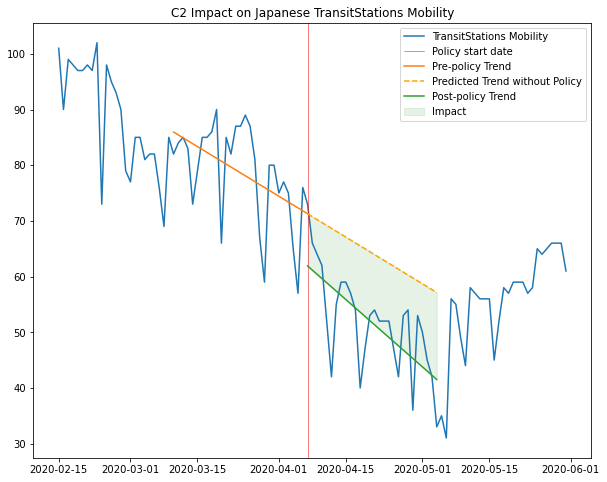

In [269]:
# set parameters
policy_date = pd.to_datetime('2020-04-07')
data_set = mobility_data['TransitStations']
country = 'Japan'
pre_wind = 28
post_wind = 28
plot_startDate = '2020-02-15'
plot_endDate = '2020-06-01'

# get indicies
policy_ind = data_set[country].index.get_loc(policy_date)
pre_day = policy_date - timedelta(days = pre_wind)
pre_ind = data_set[country].index.get_loc(pre_day)
post_day = policy_date + timedelta(days = post_wind)
post_ind = data_set[country].index.get_loc(post_day)

## perform regressions
# pre-window regression
pre_y = np.array(data_set[country][pre_ind:(policy_ind+1)].dropna().values, dtype='float')
pre_x = np.array(data_set[country][pre_ind:(policy_ind+1)].dropna().index.values, dtype='float')
pre_slope, pre_intercept, r_value, p_value, std_err = stats.linregress(pre_x, pre_y)
xf = np.linspace(min(pre_x), max(pre_x), 100)
pre_xf = xf.copy()
pre_xf = pd.to_datetime(pre_xf)
def pre_f(x):
    return (pre_slope*x)+pre_intercept
pre_yf = pre_f(xf)

# dashed pre-regression line
dashed_xf = np.linspace(min(post_x), max(post_x), 100)
dashed_pre_xf = dashed_xf.copy()
dashed_pre_xf = pd.to_datetime(dashed_pre_xf)
dashed_pre_yf = (pre_slope*dashed_xf)+pre_intercept

# post-window regression
post_y = np.array(data_set[country][policy_ind:post_ind].dropna().values, dtype='float')
post_x = np.array(data_set[country][policy_ind:post_ind].dropna().index.values, dtype='float')
post_slope, post_intercept, r_value, p_value, std_err = stats.linregress(post_x, post_y)
xf = np.linspace(min(post_x),max(post_x), 100)
post_xf = xf.copy()
post_xf = pd.to_datetime(post_xf)
def post_f(x):
    return (post_slope*x)+post_intercept
post_yf = post_f(xf)

# plot lines
start_ind = data_set[country].index.get_loc(plot_startDate)
end_ind = data_set[country].index.get_loc(plot_endDate)
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(data_set[country][start_ind:end_ind])
plt.title('C2 Impact on Japanese TransitStations Mobility')
plt.axvline(x=policy_date, color='r', linestyle='-', linewidth=0.5)
plt.plot(pre_xf, pre_yf)
plt.plot(dashed_pre_xf, dashed_pre_yf, color='orange', linestyle='--')
plt.plot(post_xf, post_yf)
plt.fill_between(post_xf, dashed_pre_yf, post_yf, color='g', alpha = 0.1)
plt.legend(loc='upper right', labels=('TransitStations Mobility', 'Policy start date','Pre-policy Trend', 'Predicted Trend without Policy', 
                                      'Post-policy Trend', 'Impact'))

In [272]:
# calculate area between pre-policy and post-policy trend lines
area = lambda x: post_f(x) - pre_f(x)
impact_area = integrate.quad(area, a= min(post_x), b=max(post_x))[0]
print('Impact Area:', impact_area)
full_area = integrate.quad(pre_f, a= min(post_x), b=max(post_x))[0]
print('Full Area:', full_area)

# relative impact (to get rid of units)
impact_score = impact_area/full_area
print('Impact score:', impact_score)

Impact Area: -2.9142762561576664e+16
Full Area: 1.4978184827586323e+17
Impact score: -0.19456805278502434
